# Analysis of probe models

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns

import numpy as np
import pandas as pd

import statsmodels.formula.api as smf
import torch

In [2]:
from model import ClassifierWithTTA
from safetensors import safe_open

def load_model(classifier_hidden_layers):
    folder = {
                0: "linear_probe",
                2: "vit2_probe",
                4: "vit4_probe"
             }.get(classifier_hidden_layers)
    
    tensors = {}
    with safe_open(f"{folder}/checkpoint-62500/model.safetensors", framework="pt", device="cpu") as f:
        for key in f.keys():
            tensors[key] = f.get_tensor(key)

    model = ClassifierWithTTA(classifier_hidden_layers=classifier_hidden_layers)
    model.load_state_dict(tensors)

    return model

W0909 12:00:18.032000 20395 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


import error: No module named 'triton'


In [3]:
linear_model = load_model(0)
vit2_model = load_model(2)
vit4_model = load_model(4)

#### Double check that the encoders did not train

In [7]:
linear_params = list(linear_model.embedding.parameters())
vit2_params = list(vit4_model.embedding.parameters())
vit4_params = list(vit4_model.embedding.parameters())

In [9]:
linTo2 = []
linTo4 = []

for i in range( len(linear_params)):
    linTo2.append( (linear_params[i] == vit2_params[i]).all())
    linTo4.append( (linear_params[i] == vit4_params[i]).all())
    

In [10]:
all(linTo2)

True

In [11]:
all(linTo4)

True

Looks good.

## Baseline accuracy

This is on the validation set, which I also used as a development set.

In [7]:
from data_management import fetch_dataset_from_hf

train, val = fetch_dataset_from_hf() 


In [30]:
import torchmetrics

def compute_accuracy(model, data):
    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=200)
    dl = torch.utils.data.DataLoader(data, batch_size=64)

    model.to('mps')
    
    for batch in iter(dl):
        preds = model.forward(batch[0].to('mps')).logits
        accuracy.update(preds.cpu(), batch[1])

    model.to('cpu')
    return accuracy


In [31]:
compute_accuracy(linear_model, val).compute()

tensor(0.5168)

In [32]:
compute_accuracy(vit2_model, val).compute()

tensor(0.7095)

In [33]:
compute_accuracy(vit4_model, val).compute()

tensor(0.7030)

These accuracies aren't great (in particular the linear probing one), but I think that they are sufficient for investigation of TTA

## Accuracy on corrupted datasets:

In [2]:
from model import ClassifierWithTTA
from safetensors import safe_open

def load_model(classifier_hidden_layers):
    folder = {
                0: "linear_probe",
                2: "vit2_probe",
                4: "vit4_probe"
             }.get(classifier_hidden_layers)
    
    tensors = {}
    with safe_open(f"{folder}/checkpoint-62500/model.safetensors", framework="pt", device="cpu") as f:
        for key in f.keys():
            tensors[key] = f.get_tensor(key)

    model = ClassifierWithTTA(classifier_hidden_layers=classifier_hidden_layers)
    model.load_state_dict(tensors)

    return model

import torchmetrics

def compute_accuracy(model, data):
    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=200)
    dl = torch.utils.data.DataLoader(data, batch_size=64)

    model.to('mps')
    
    for batch in iter(dl):
        preds = model.forward(batch[0].to('mps')).logits
        accuracy.update(preds.cpu(), batch[1])

    model.to('cpu')
    return accuracy


W0910 13:26:06.524000 1141 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


import error: No module named 'triton'


In [3]:
from data_management import fetch_dataset


In [4]:
%run dataset_files/metadata.py

all_corruptions = [None] + corruption_names_train + corruption_names_val

In [5]:
results = []
for num_layers in [0,2,4]:
    model = load_model(num_layers)
    for corruption_name in all_corruptions:
        if corruption_name is None:
            fname = 'dataset_files/uncorrupted_valid.npz'
        else:
            fname = f'dataset_files/corrupted_{corruption_name}_severity5_valid.npz'
    
        data = fetch_dataset(fname)
        acc = compute_accuracy(model, data)
        results.append({'model_layers': num_layers, 'corruption': corruption_name, 'accuracy': acc.compute()})

        del data
        print(num_layers, corruption_name)
    del model

0 None
0 gaussian_noise
0 shot_noise
0 impulse_noise
0 defocus_blur
0 glass_blur
0 motion_blur
0 zoom_blur
0 snow
0 frost
0 fog
0 brightness
0 contrast
0 elastic_transform
0 pixelate
0 jpeg_compression
0 speckle_noise
0 gaussian_blur
0 spatter
0 saturate
2 None
2 gaussian_noise
2 shot_noise
2 impulse_noise
2 defocus_blur
2 glass_blur
2 motion_blur
2 zoom_blur
2 snow
2 frost
2 fog
2 brightness
2 contrast
2 elastic_transform
2 pixelate
2 jpeg_compression
2 speckle_noise
2 gaussian_blur
2 spatter
2 saturate
4 None
4 gaussian_noise
4 shot_noise
4 impulse_noise
4 defocus_blur
4 glass_blur
4 motion_blur
4 zoom_blur
4 snow
4 frost
4 fog
4 brightness
4 contrast
4 elastic_transform
4 pixelate
4 jpeg_compression
4 speckle_noise
4 gaussian_blur
4 spatter
4 saturate


In [26]:
accuracy_results = pd.DataFrame(results)
accuracy_results.accuracy = accuracy_results.accuracy.map(lambda x: x.item())
accuracy_results = accuracy_results.fillna('None')

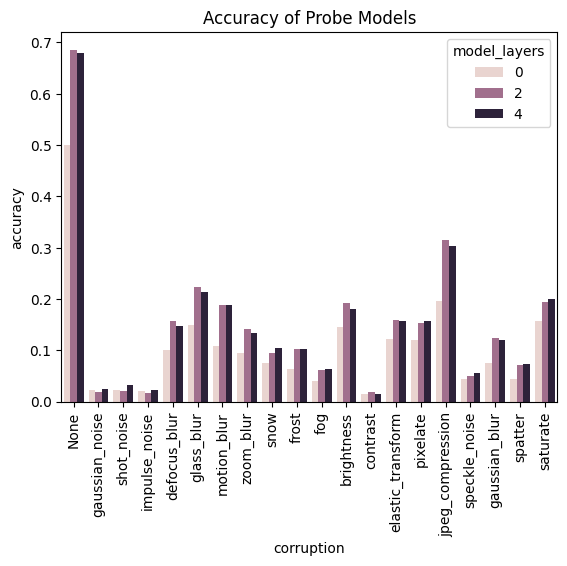

In [33]:
plt.title('Accuracy of Probe Models')
sns.barplot(accuracy_results, x="corruption", y="accuracy", hue="model_layers")
_=plt.xticks(rotation=90)

Ok. There is a _substantial_ drop in accuracy for all models and all noise types. For the most part, the gap between linear and vit performance persists across corruptions.

In [35]:
accuracy_results.to_csv('accuracy_probe.csv')

### Accuracy of full trained models:

In [37]:
def load_model_full(classifier_hidden_layers):
    folder = {
                0: "linear_full",
                2: "vit2_full",
                4: "vit4_full"
             }.get(classifier_hidden_layers)
    
    tensors = {}
    with safe_open(f"{folder}/checkpoint-37500/model.safetensors", framework="pt", device="cpu") as f:
        for key in f.keys():
            tensors[key] = f.get_tensor(key)

    model = ClassifierWithTTA(classifier_hidden_layers=classifier_hidden_layers)
    model.load_state_dict(tensors)

    return model

In [38]:
results_full = []
for num_layers in [0,2,4]:
    model = load_model_full(num_layers)
    for corruption_name in all_corruptions:
        if corruption_name is None:
            fname = 'dataset_files/uncorrupted_valid.npz'
        else:
            fname = f'dataset_files/corrupted_{corruption_name}_severity5_valid.npz'
    
        data = fetch_dataset(fname)
        acc = compute_accuracy(model, data)
        results_full.append({'model_layers': num_layers, 'corruption': corruption_name, 'accuracy': acc.compute()})

        del data
        print(num_layers, corruption_name)
    del model

0 None
0 gaussian_noise
0 shot_noise
0 impulse_noise
0 defocus_blur
0 glass_blur
0 motion_blur
0 zoom_blur
0 snow
0 frost
0 fog
0 brightness
0 contrast
0 elastic_transform
0 pixelate
0 jpeg_compression
0 speckle_noise
0 gaussian_blur
0 spatter
0 saturate
2 None
2 gaussian_noise
2 shot_noise
2 impulse_noise
2 defocus_blur
2 glass_blur
2 motion_blur
2 zoom_blur
2 snow
2 frost
2 fog
2 brightness
2 contrast
2 elastic_transform
2 pixelate
2 jpeg_compression
2 speckle_noise
2 gaussian_blur
2 spatter
2 saturate
4 None
4 gaussian_noise
4 shot_noise
4 impulse_noise
4 defocus_blur
4 glass_blur
4 motion_blur
4 zoom_blur
4 snow
4 frost
4 fog
4 brightness
4 contrast
4 elastic_transform
4 pixelate
4 jpeg_compression
4 speckle_noise
4 gaussian_blur
4 spatter
4 saturate


In [39]:
accuracy_results_full = pd.DataFrame(results_full)
accuracy_results_full.accuracy = accuracy_results_full.accuracy.map(lambda x: x.item())
accuracy_results_full = accuracy_results_full.fillna('None')

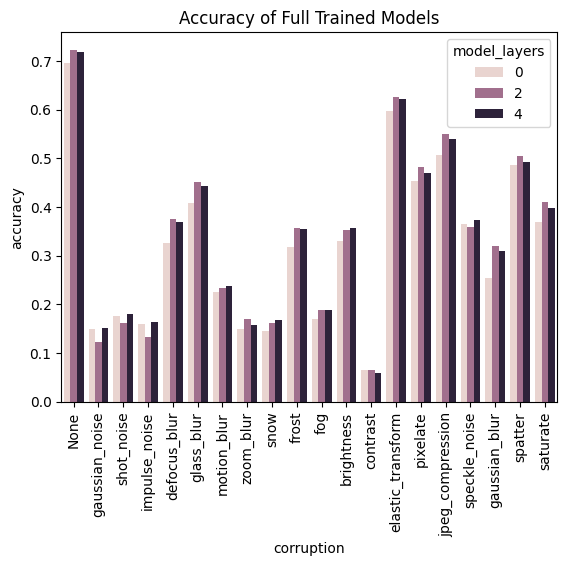

In [41]:
plt.title('Accuracy of Full Trained Models')
sns.barplot(accuracy_results_full, x="corruption", y="accuracy", hue="model_layers")
_=plt.xticks(rotation=90)

Interesting. Full model finetuning has a significantly better baseline performance on corrupted datasets. Also, the gap between linear and vit models has vanished.

A priori, I could have seen arguments in either direction that improved specialization of the model to the dataset leads to better / worse performance. I'd like to double check this at some point, maybe with a different dataset.

In [42]:
accuracy_results_full.to_csv('results_data/accuracy_full.csv')

## Test-time adaptation